# Install packages

In [161]:
!pip install -q -U --upgrade google-auth google-api-python-client
!pip install -q -U gspread
!pip install -q -U google-generativeai

!pip install -q langchain
!pip install -q langchain-google-genai
!pip install -q pydantic

!pip install -q matplotlib 
!pip install -q pandas
!pip install -q fpdf2 
!pip install -q google-auth-httplib2
!pip install -q Pillow


# Set up Google Drive API credentials

In [162]:
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

SERVICE_ACCOUNT_FILE = 'secrets/google_drive_api_credentials.json'

SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/spreadsheets']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('drive', 'v3', credentials=creds)

# Connect to Google Drive Folder

In [163]:

def find_folder(folder_name):
    """Search for a folder by name and return its ID."""
    results = service.files().list(
        q=f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}'",
        spaces='drive',
        fields='nextPageToken, files(id, name)').execute()
    folders = results.get('files', [])

    if folders:
        return folders[0]['id'] 
    return None

def list_files_in_folder(folder_id):
    """List all files in the specified Google Drive folder."""
    results = service.files().list(
        q=f"'{folder_id}' in parents",
        spaces='drive',
        fields='nextPageToken, files(id, name, mimeType)').execute()
    files = results.get('files', [])

    if files:
        return files
    return []


Replace "folder_name" with the name of the folder where your Google Sheet is stored.

In [ ]:
folder_name = 'google_AI_hackathon'
folder_id = find_folder(folder_name)
files_info = {}  

if folder_id:
    print(f"Found folder 'google_AI_hackathon' with ID: {folder_id}")
    files = list_files_in_folder(folder_id)
    for file in files:
        file_name = file['name']
        file_id = file['id']

        files_info[file_name] =  file_id
else:
    print("Folder not found.")

for file_name, info in files_info.items():
    print(f"File Name: {file_name}, ID: {info}")



# Open Google Sheet

In [165]:
import gspread
import pandas as pd


gc = gspread.authorize(creds)

Replace "spreadsheet_name" with the name of the Google Sheet you want to derive insights from.

In [166]:
spreadsheet_name = "vehicle_sales"
spreadsheet_key = files_info[spreadsheet_name]
workbook = gc.open_by_key(spreadsheet_key)
sheet = workbook.worksheet('Sheet1')

data = sheet.get_all_records()
df = pd.DataFrame(data)

print(df)

     Year Month    New   Used  Total Sales New  Total Sales Used
0    2002   JAN  31106  49927        755015820         386481929
1    2002   FEB  27520  50982        664454223         361353242
2    2002   MAR  34225  58794        805666244         419385387
3    2002   APR  36452  59817        846368297         433061150
4    2002   MAY  37359  60577        855005784         442569410
..    ...   ...    ...    ...              ...               ...
259  2023   AUG  25876  52725       1222581892         908454060
260  2023   SEP  23892  45386       1134437699         744676584
261  2023   OCT  23775  45473       1122680147         740582533
262  2023   NOV  22720  42260       1062465105         694190564
263  2023   DEC  26010  40556       1233234965         674734577

[264 rows x 6 columns]


# Set up Gemini credentials

In [167]:
import json

with open('secrets/google_gemini_credentials.json') as f:
    secrets = json.load(f)

GOOGLE_API_KEY=secrets['GOOGLE_API_KEY']


In [168]:
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [169]:
import os
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# Generate graphs from dataframe

In [172]:
schema = df.dtypes.to_string()
print("Schema:\n", schema)

columns_for_visualization = df.columns.to_list()
print("Columns for visualisation:\n", columns_for_visualization)

Schema:
 Year                 int64
Month               object
New                  int64
Used                 int64
Total Sales New      int64
Total Sales Used     int64
Columns for visualisation:
 ['Year', 'Month', 'New', 'Used', 'Total Sales New', 'Total Sales Used']


In [173]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

llm = ChatGoogleGenerativeAI(model = 'gemini-pro', temperature = 0)

template = """As a data analyst, your objective is to derive valuable insights from the dataset using visualization. 
Utilizing the {data} from the dataframe, craft Python code to generate a maximum of 5 insightful graphs, ensuring each graph is stored as a variable.

Refer to the schema {schema_info} of the dataframe.
Only use the following columns for visualization {columns_for_visualization}

A dataframe named 'df' already exists.

Each graph should be generated and stored in a separate variable (e.g., fig1, fig2, etc.) for easy access and manipulation. This will allow further actions such as saving the figures to files.

"""



prompt_template = PromptTemplate(input_variables = ["data", "schema_info", "columns_for_visualization"], template = template, verbose = True)
chain = LLMChain(llm=llm, prompt=prompt_template)

llm_input = {"data": df, "schema_info": schema, "columns_for_visualization": columns_for_visualization}

answer = chain.invoke(input = llm_input)

In [174]:
print(answer['text'])

```python
import matplotlib.pyplot as plt
import pandas as pd

# Create a line chart of Total Sales New over time
fig1 = plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Total Sales New'])
plt.xlabel('Year')
plt.ylabel('Total Sales New')
plt.title('Total Sales New Over Time')

# Create a line chart of Total Sales Used over time
fig2 = plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Total Sales Used'])
plt.xlabel('Year')
plt.ylabel('Total Sales Used')
plt.title('Total Sales Used Over Time')

# Create a bar chart of New and Used sales for each month
fig3 = plt.figure(figsize=(12, 6))
plt.bar(df['Month'], df['New'], label='New')
plt.bar(df['Month'], df['Used'], label='Used')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('New and Used Sales by Month')
plt.legend()

# Create a scatter plot of Total Sales New vs. Total Sales Used
fig4 = plt.figure(figsize=(12, 6))
plt.scatter(df['Total Sales New'], df['Total Sales Used'])
plt.xlabel('Total Sales New')
plt.ylabel('Total Sales Use

In [175]:
from pydantic import BaseModel
import re

class PythonFunctionParser(BaseModel):
    
    @classmethod
    def parse(cls, llm_input):
        pattern = r"```python(.*?)```"
        functions = re.findall(pattern, llm_input, re.MULTILINE | re.DOTALL)
        if functions:
            python_function = functions[0].strip()  
        else:
            python_function = ""  
        
        return python_function

In [176]:
parsed_output = PythonFunctionParser.parse(answer['text'])
print(parsed_output)

import matplotlib.pyplot as plt
import pandas as pd

# Create a line chart of Total Sales New over time
fig1 = plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Total Sales New'])
plt.xlabel('Year')
plt.ylabel('Total Sales New')
plt.title('Total Sales New Over Time')

# Create a line chart of Total Sales Used over time
fig2 = plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Total Sales Used'])
plt.xlabel('Year')
plt.ylabel('Total Sales Used')
plt.title('Total Sales Used Over Time')

# Create a bar chart of New and Used sales for each month
fig3 = plt.figure(figsize=(12, 6))
plt.bar(df['Month'], df['New'], label='New')
plt.bar(df['Month'], df['Used'], label='Used')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('New and Used Sales by Month')
plt.legend()

# Create a scatter plot of Total Sales New vs. Total Sales Used
fig4 = plt.figure(figsize=(12, 6))
plt.scatter(df['Total Sales New'], df['Total Sales Used'])
plt.xlabel('Total Sales New')
plt.ylabel('Total Sales Used')
plt.ti

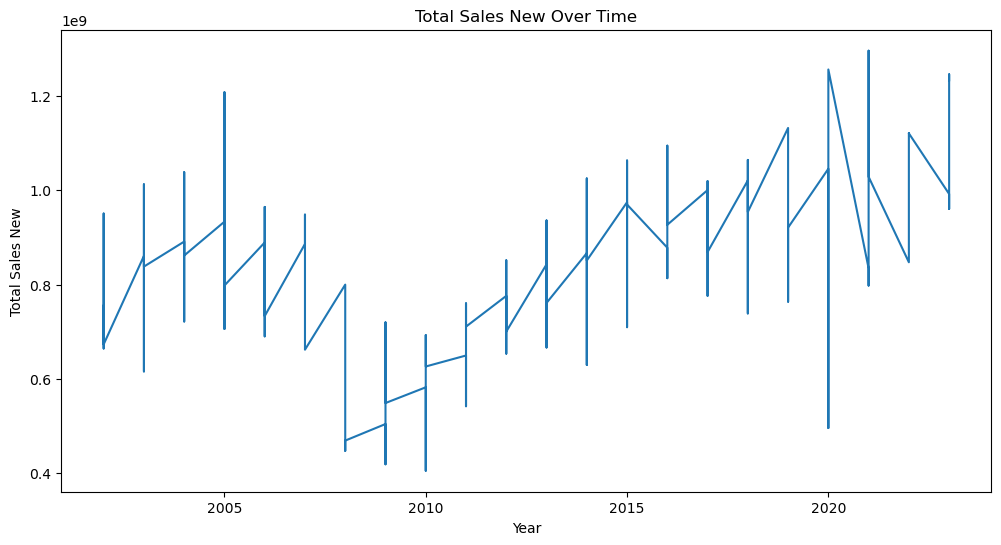

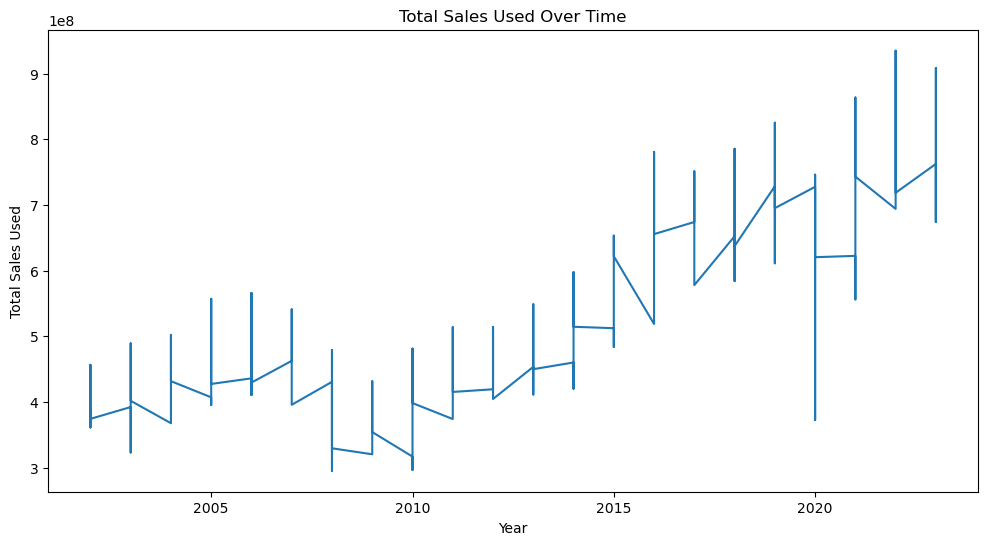

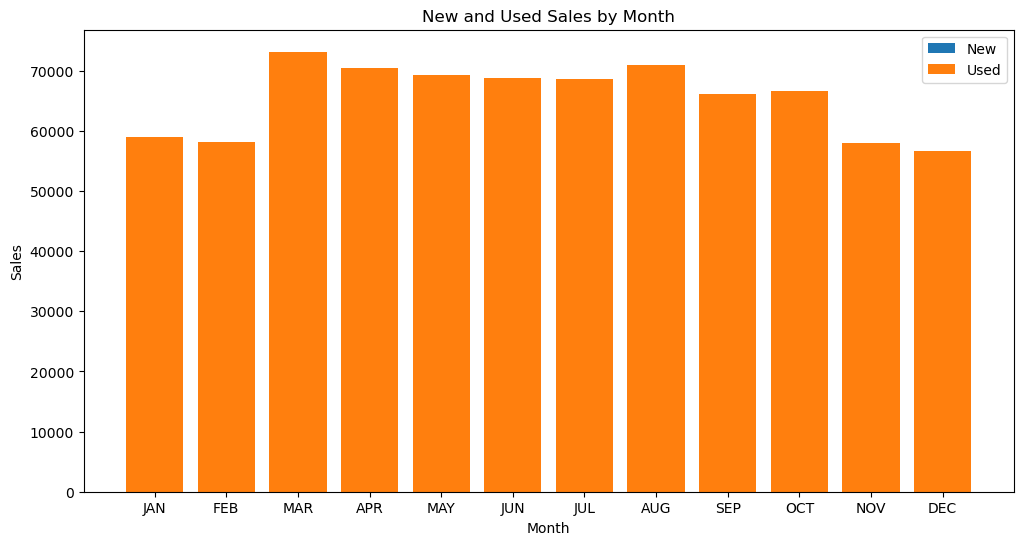

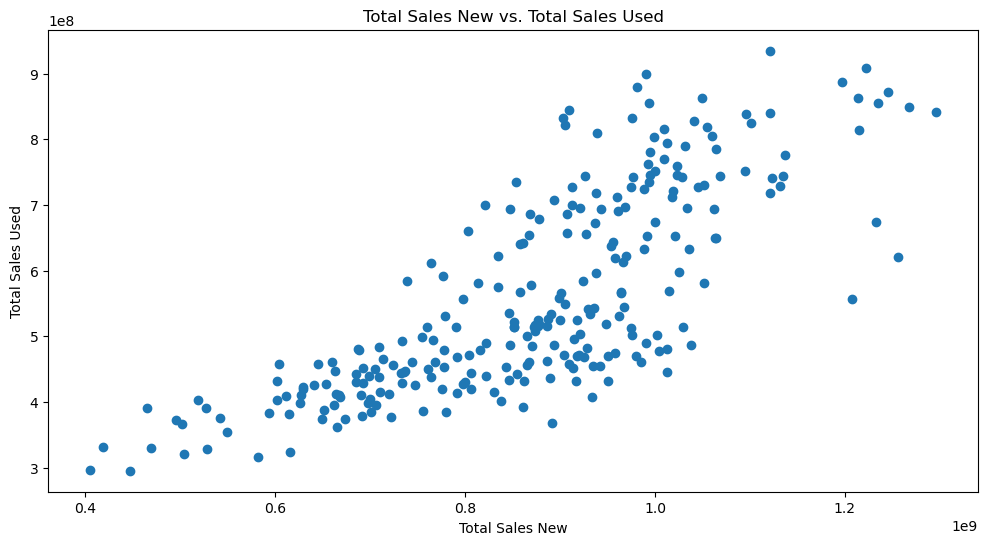

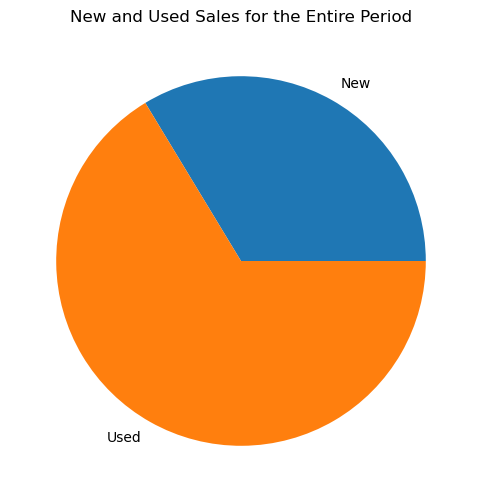

In [177]:
exec(parsed_output)

In [178]:
fig1.savefig('image.png')

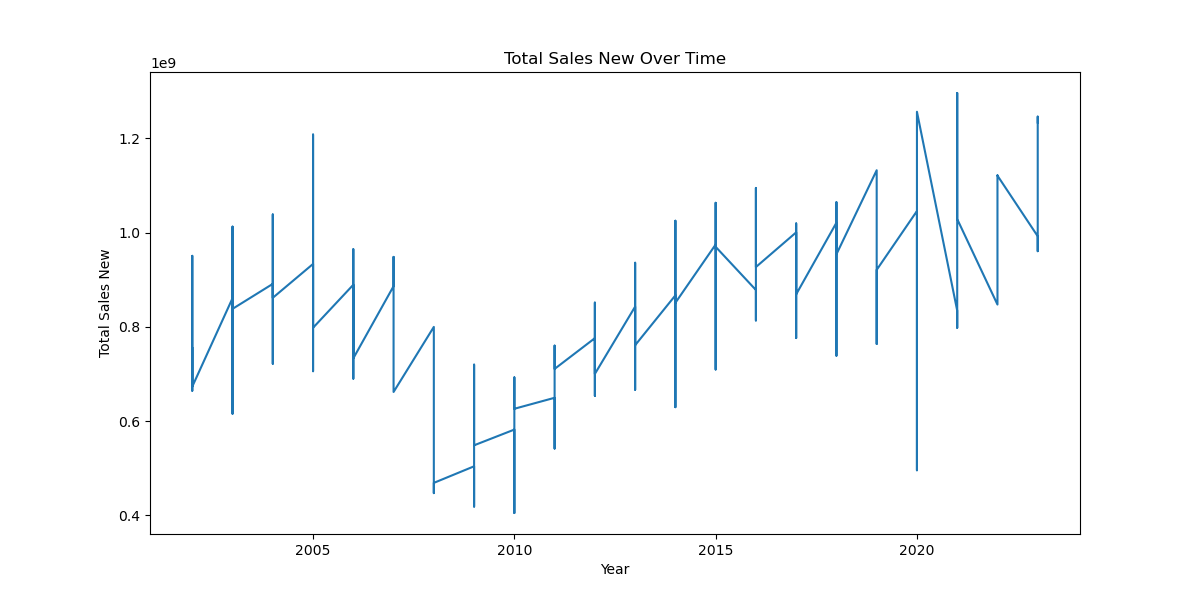

In [179]:
import PIL.Image

img = PIL.Image.open('image.png')
img

# Generate insights from graphs

In [ ]:
import google.generativeai as genai
from fpdf import FPDF
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import io

model = genai.GenerativeModel('gemini-pro-vision')

about_dataset = "The dataset provides a comprehensive record of the annual sales counts of vehicles spanning from 2002 to 2023. It offers valuable insights into the trends and patterns of vehicle sales over the years, allowing analysts and stakeholders to understand the dynamics of the automotive market and make informed decisions. With this dataset, researchers can explore how factors such as economic conditions, technological advancements, and consumer preferences have influenced vehicle sales trends over the specified timeframe."
template_explanation = """Answer only in English. As a data scientist, analyze the provided graph and provide a detailed summary along with insights gained. 
Ensure your answer is relevant to the dataset description provided ({about_dataset}).
Consider the following points:

1. Trend: 
Describe the trend or patterns visible in the graph.

2. Anomalies: 
Identify any anomalies or outliers present.

3. Correlation: 
Discuss any correlations or relationships between variables depicted in the graph.

4. Implication: 
Interpret the implications of the observed trends or patterns for the business or research context.

5. Recommendation: 
Propose potential actions or recommendations based on the insights derived from the graph.

Format the text in an easy-to-understand format for quick reference. Leave a line break after every numbered point.
"""



figures = [fig1, fig2, fig3, fig4, fig5] 

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Graph Insights Report', 0, 1, 'C')

    def chapter_title(self, num):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, '', 0, 1)
        self.cell(0, 10, 'Graph %d' % (num), 0, 1, 'L')

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        lines = body.split('\n')
        for line in lines:
            if '<b>' in line and '</b>' in line:
                parts = line.replace('<b>', '\b').replace('</b>', '\b').split('\b')
                for part in parts:
                    if part.startswith('<b>'):
                        self.set_font('Arial', 'B', 12) 
                        part = part[3:]
                    elif part.endswith('</b>'):
                        part = part[:-4]
                    self.cell(self.get_string_width(part) + 2, 10, part, 0)
                    self.set_font('Arial', '', 12)  
            else:
                self.multi_cell(0, 5, line)
            self.ln(0.5) 

    def remove_non_english(self, text):
        return re.sub(r'[^\x00-\x7F]+', ' ', text)

pdf = PDF()
pdf.add_page()
pdf_width = pdf.w - (2 * pdf.l_margin)

img_width = 190  

x_coordinate = (pdf_width - img_width) / 2


for i, fig in enumerate(figures, start=1):
    if fig is not None:
        canvas = FigureCanvas(fig)
        canvas.draw()
        s, (width, height) = canvas.print_to_buffer()

        img = Image.frombytes("RGBA", (width, height), s, "raw", "RGBA", 0, 1)
        img = img.convert("RGB")
        print(type(img))


        # Generate insights
        prompt = [template_explanation, img]
        response = model.generate_content(prompt, stream=True)
        response.resolve()

        
        # Filter non-english words
        filtered_text = pdf.remove_non_english(response.text)
        print(filtered_text)
        filtered_response_text = filtered_text.replace('**', '')  
        filtered_response_text = filtered_response_text.replace('**', '')

        # add to pdf
        pdf.chapter_title(i)
        pdf.image(img, x=x_coordinate, y=None, w=img_width)
        pdf.chapter_body(filtered_response_text)


pdf.output('graph_insights_report.pdf')


# Save to Google Drive

Replace "folder_name" with the name of the Google Drive folder you want to save the insights report to.

In [ ]:
from googleapiclient.http import MediaFileUpload

folder_name = 'google_AI_hackathon'

folder_id = find_folder(folder_name)

if folder_id:
    print(f"Found folder '{folder_name}' with ID: {folder_id}")

    file_metadata = {
        'name': 'GraphInsightsReport.pdf',
        'parents': [folder_id]  
    }

    media = MediaFileUpload('graph_insights_report.pdf',
                            mimetype='application/pdf')

    file = service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

    print('File ID: %s' % file.get('id'))
else:
    print(f"Folder '{folder_name}' not found.")
